In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import parquet

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb

We will use November data to analyse and walkthrough the data and try to see the relationships between data



In [5]:
!pip install xgboost

  Using cached xgboost-1.7.5-py3-none-win_amd64.whl (70.9 MB)


In [7]:
nyc_df_raw = pd.read_parquet("../data/raw/")
nyc_df_raw.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-09-01 00:28:12,2022-09-01 00:36:22,1.0,2.10,1.0,N,100,239,1,9.0,3.0,0.5,1.8,0.00,0.3,14.60,2.5,0.0
1,1,2022-09-01 00:51:58,2022-09-01 01:14:43,1.0,8.70,1.0,N,161,243,2,27.5,3.0,0.5,0.0,0.00,0.3,31.30,2.5,0.0
2,1,2022-09-01 00:08:29,2022-09-01 00:26:29,1.0,8.30,1.0,N,138,233,1,25.0,3.0,0.5,2.0,6.55,0.3,37.35,2.5,0.0
3,2,2022-09-01 00:02:24,2022-09-01 00:09:39,1.0,1.32,1.0,N,238,166,2,7.5,0.5,0.5,0.0,0.00,0.3,8.80,0.0,0.0
4,2,2022-09-01 00:47:25,2022-09-01 00:56:09,1.0,2.94,1.0,N,161,226,2,10.5,0.5,0.5,0.0,0.00,0.3,14.30,2.5,0.0


Our target column would be price which we would predict based of the drop of location. But first we need to predicted estimated time and then feed that time as input to out model to predict estimated price.

### Lets first see the data

In [8]:
nyc_df_raw.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

We will drop columns  `[ 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']` we wont be needing these to predict base fare amount as this are extra charges and would be calculated after the ride is done.

In [10]:
drop_columns = [ 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

In [11]:
nyc_df = nyc_df_raw.drop(drop_columns, axis=1)
nyc_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount
0,1,2022-09-01 00:28:12,2022-09-01 00:36:22,1.0,2.10,1.0,N,100,239,1,9.0
1,1,2022-09-01 00:51:58,2022-09-01 01:14:43,1.0,8.70,1.0,N,161,243,2,27.5
2,1,2022-09-01 00:08:29,2022-09-01 00:26:29,1.0,8.30,1.0,N,138,233,1,25.0
3,2,2022-09-01 00:02:24,2022-09-01 00:09:39,1.0,1.32,1.0,N,238,166,2,7.5
4,2,2022-09-01 00:47:25,2022-09-01 00:56:09,1.0,2.94,1.0,N,161,226,2,10.5


In [12]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16578210 entries, 0 to 16578209
Data columns (total 11 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
dtypes: datetime64[ns](2), float64(4), int64(4), object(1)
memory usage: 1.4+ GB


Datatype seems to be okay and we wont need to change the datatypes, as date time columns and numeric columns are in their respective datatypes

We will create a new column as the trip_time based on the tpep_pickup_datetime',
 'tpep_dropoff_datetime' column

In [13]:
nyc_df['trip_time'] = nyc_df['tpep_dropoff_datetime']-nyc_df['tpep_pickup_datetime']

In [8]:
nyc_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,trip_time
0,1,2022-09-01 00:28:12,2022-09-01 00:36:22,1.0,2.10,1.0,N,100,239,1,9.0,0 days 00:08:10
1,1,2022-09-01 00:51:58,2022-09-01 01:14:43,1.0,8.70,1.0,N,161,243,2,27.5,0 days 00:22:45
2,1,2022-09-01 00:08:29,2022-09-01 00:26:29,1.0,8.30,1.0,N,138,233,1,25.0,0 days 00:18:00
3,2,2022-09-01 00:02:24,2022-09-01 00:09:39,1.0,1.32,1.0,N,238,166,2,7.5,0 days 00:07:15
4,2,2022-09-01 00:47:25,2022-09-01 00:56:09,1.0,2.94,1.0,N,161,226,2,10.5,0 days 00:08:44


we need to convert it into minutes or seconds i think

In [14]:
nyc_df['trip_time'].head()

0   0 days 00:08:10
1   0 days 00:22:45
2   0 days 00:18:00
3   0 days 00:07:15
4   0 days 00:08:44
Name: trip_time, dtype: timedelta64[ns]

In [15]:
nyc_df['trip_time'] = nyc_df['trip_time'].dt.total_seconds() / 60

In [16]:
nyc_df['trip_time'].head()

0     8.166667
1    22.750000
2    18.000000
3     7.250000
4     8.733333
Name: trip_time, dtype: float64

we have converted the trip_time column to minutes, lets round off it to 2 decimals

In [17]:
nyc_df['trip_time']=nyc_df['trip_time'].round(2)
nyc_df['trip_time'].head()

0     8.17
1    22.75
2    18.00
3     7.25
4     8.73
Name: trip_time, dtype: float64

Lets extract day of the week and day of the month from the pickup date

In [18]:
nyc_df['day_week'] = nyc_df['tpep_pickup_datetime'].dt.day_name()
nyc_df['day_month'] = nyc_df['tpep_pickup_datetime'].dt.day

In [19]:
nyc_df[['day_month','day_week','tpep_pickup_datetime']].sample(5)

,day_month,day_week,tpep_pickup_datetime
1159122,12,Monday,2022-09-12 12:57:22
2215832,23,Friday,2022-09-23 12:47:27
2801615,28,Wednesday,2022-09-28 20:39:12
13534815,1,Sunday,2023-01-01 07:44:41
9325088,24,Thursday,2022-11-24 00:51:40


In [15]:
nyc_df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'trip_time',
 'day_week',
 'day_month']

In [20]:
nyc_df.isna().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          569777
trip_distance                 0
RatecodeID               569777
store_and_fwd_flag       569777
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
trip_time                     0
day_week                      0
day_month                     0
dtype: int64

We can delete 'tpep_pickup_datetime','tpep_dropoff_datetime','passenger_count', 'RatecodeID','store_and_fwd_flag'

In [21]:
to_drop = [ 'tpep_pickup_datetime','tpep_dropoff_datetime','passenger_count', 'RatecodeID','store_and_fwd_flag','payment_type']
nyc_df = nyc_df.drop(to_drop,axis=1)

In [22]:
nyc_df.isnull().sum()

VendorID         0
trip_distance    0
PULocationID     0
DOLocationID     0
fare_amount      0
trip_time        0
day_week         0
day_month        0
dtype: int64

In [23]:
nyc_df.describe().astype(int)

,VendorID,trip_distance,PULocationID,DOLocationID,fare_amount,trip_time,day_month
count,16578210,16578210,16578210,16578210,16578210,16578210,16578210
mean,1,5,165,163,5,17,15
std,0,562,65,70,34533,46,8
min,1,0,1,1,-133391414,-1397,1
25%,1,1,132,113,7,7,8
50%,2,1,162,162,11,12,15
75%,2,3,234,234,18,20,23
max,6,389678,265,265,187444,10029,31


## Univariate Analysis

In [24]:
fare_threshold = np.percentile(nyc_df['fare_amount'], 99.9)
nyc_df[nyc_df['fare_amount'] > fare_threshold]

,VendorID,trip_distance,PULocationID,DOLocationID,fare_amount,trip_time,day_week,day_month
781,1,24.90,100,265,143.00,46.53,Thursday,1
817,1,0.00,265,265,125.00,1.03,Thursday,1
1674,2,24.02,70,265,168.00,22.70,Thursday,1
2023,2,0.00,132,132,150.00,0.13,Thursday,1
2115,1,0.00,265,265,184.00,0.55,Thursday,1
...,...,...,...,...,...,...,...,...
16545604,2,34.62,141,265,138.71,83.53,Wednesday,18
16546670,2,21.07,41,1,145.27,52.52,Thursday,19
16553960,2,24.70,113,265,134.28,45.02,Saturday,21
16564620,2,22.71,74,1,154.46,55.17,Thursday,26


In [25]:
nyc_df[['fare_amount','trip_time']].sort_values(by='fare_amount',ascending=False).astype(int)

,fare_amount,trip_time
2367479,187444,9
2608166,9999,46
10149156,5901,0
13304886,1633,2221
4382145,1294,331
...,...,...
8886295,-1274,0
4382144,-1294,331
13304885,-1633,2221
13447126,-44463768,33


Text(0, 0.5, 'Count')

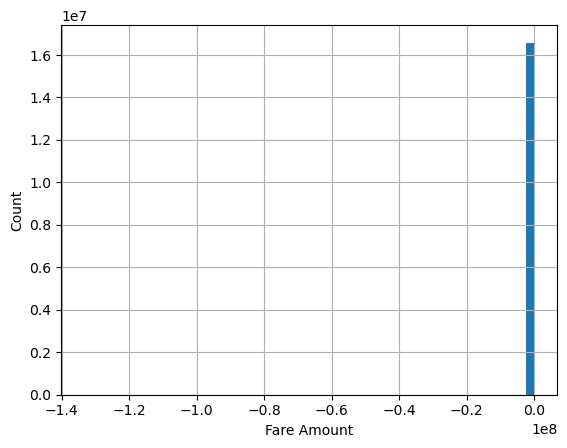

In [26]:
nyc_df['fare_amount'].hist(bins=50)
plt.xlabel('Fare Amount')
plt.ylabel('Count')

In [27]:
nyc_df[nyc_df['fare_amount']<0][['fare_amount','trip_time']].sample(10)

,fare_amount,trip_time
8187007,-10.5,9.62
500367,-10.0,13.95
8237549,-11.5,13.27
11601713,-5.5,5.35
5721202,-4.5,4.27
14679399,-5.1,3.20
2080093,-18.5,18.00
14619730,-12.8,13.37
2675029,-6.5,11.17
13914060,-21.9,16.77


Seems like we have negative values, and comaring them to trip time seems like it is correct amount just in negative.So we will convert them to positive values

In [28]:
nyc_df['fare_amount'] = nyc_df['fare_amount'].abs()

In [29]:
nyc_df[nyc_df['fare_amount']==0][['fare_amount','trip_time']]

,fare_amount,trip_time
797,0.0,0.00
5285,0.0,0.43
6489,0.0,0.33
6710,0.0,40.05
6711,0.0,40.05
...,...,...
16549449,0.0,15.28
16557487,0.0,0.33
16567106,0.0,0.98
16569792,0.0,2.58


In [30]:
nyc_df[nyc_df['fare_amount']==0][['fare_amount','trip_time']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6714 entries, 797 to 16572199
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fare_amount  6714 non-null   float64
 1   trip_time    6714 non-null   float64
dtypes: float64(2)
memory usage: 157.4 KB


In [31]:
nyc_df_raw[nyc_df_raw['fare_amount']==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6714 entries, 797 to 16572199
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               6714 non-null   int64         
 1   tpep_pickup_datetime   6714 non-null   datetime64[ns]
 2   tpep_dropoff_datetime  6714 non-null   datetime64[ns]
 3   passenger_count        6640 non-null   float64       
 4   trip_distance          6714 non-null   float64       
 5   RatecodeID             6640 non-null   float64       
 6   store_and_fwd_flag     6640 non-null   object        
 7   PULocationID           6714 non-null   int64         
 8   DOLocationID           6714 non-null   int64         
 9   payment_type           6714 non-null   int64         
 10  fare_amount            6714 non-null   float64       
 11  extra                  6714 non-null   float64       
 12  mta_tax                6714 non-null   float64       
 1

So my guess is that the fare amount is zero because of some offers or some promotional or some other kind of payment. But we cant feed this to our model as fare amount shouldn't be zero for a taxi ride

Lets see where the fare amount =0, trip distance = 0 and trip time <2. As this can be legit data as the taxi ride is not done

In [32]:
nyc_df[(nyc_df['fare_amount'] == 0) & (nyc_df['trip_time'] <= 2) & (nyc_df['trip_distance'] ==0)]

,VendorID,trip_distance,PULocationID,DOLocationID,fare_amount,trip_time,day_week,day_month
797,1,0.0,170,264,0.0,0.00,Thursday,1
5285,1,0.0,48,48,0.0,0.43,Thursday,1
6489,1,0.0,132,132,0.0,0.33,Thursday,1
6966,1,0.0,170,170,0.0,0.38,Thursday,1
8967,2,0.0,132,132,0.0,0.13,Thursday,1
...,...,...,...,...,...,...,...,...
16486412,1,0.0,132,132,0.0,0.40,Tuesday,31
16498432,2,0.0,193,193,0.0,0.67,Tuesday,31
16557487,1,0.0,79,79,0.0,0.33,Monday,23
16567106,1,0.0,45,45,0.0,0.98,Friday,27


In [33]:
nyc_df[(nyc_df['fare_amount'] == 0) & (nyc_df['trip_time'] <= 2) & (nyc_df['trip_distance'] ==0)].sample(10)


,VendorID,trip_distance,PULocationID,DOLocationID,fare_amount,trip_time,day_week,day_month
1926671,1,0.0,145,145,0.0,0.15,Tuesday,20
947333,2,0.0,193,193,0.0,0.43,Saturday,10
8562390,2,0.0,193,193,0.0,0.40,Tuesday,15
10418037,2,0.0,264,264,0.0,0.33,Saturday,3
15558952,1,0.0,145,145,0.0,0.13,Sunday,22
3390751,2,0.0,48,48,0.0,1.07,Monday,3
817124,1,0.0,230,48,0.0,1.57,Friday,9
3840168,2,0.0,107,107,0.0,0.13,Friday,7
2709046,2,0.0,265,265,0.0,0.40,Wednesday,28
4287483,2,0.0,193,193,0.0,0.88,Tuesday,11


We will see few more combinations 

In [34]:
nyc_df[(nyc_df['fare_amount'] == 0) & (nyc_df['trip_time'] <= 2) & (nyc_df['trip_distance'] <=1)& (nyc_df['trip_distance']>0)]

,VendorID,trip_distance,PULocationID,DOLocationID,fare_amount,trip_time,day_week,day_month
15832,1,0.10,225,225,0.0,0.68,Thursday,1
15833,1,0.10,225,225,0.0,0.65,Thursday,1
15834,1,0.10,225,225,0.0,0.73,Thursday,1
38287,2,0.13,113,113,0.0,1.47,Thursday,1
38288,2,0.13,113,113,0.0,1.47,Thursday,1
...,...,...,...,...,...,...,...,...
16379991,1,0.10,229,140,0.0,1.70,Monday,30
16429438,2,0.01,90,234,0.0,0.10,Tuesday,31
16434256,2,0.01,90,234,0.0,0.10,Tuesday,31
16463406,1,0.10,142,239,0.0,1.08,Tuesday,31


In [35]:
nyc_df[(nyc_df['fare_amount'] == 0) & (nyc_df['trip_time'] <= 2) & (nyc_df['trip_distance'] <=1)& (nyc_df['trip_distance']>0)].sample(10)

,VendorID,trip_distance,PULocationID,DOLocationID,fare_amount,trip_time,day_week,day_month
4953994,1,0.20,138,138,0.0,0.98,Sunday,16
13666467,2,0.01,264,264,0.0,0.17,Tuesday,3
1767754,1,0.10,138,138,0.0,0.67,Saturday,17
16488768,1,0.10,90,90,0.0,0.53,Tuesday,31
12039540,1,0.30,262,262,0.0,1.02,Saturday,17
1874550,2,0.01,144,144,0.0,0.30,Tuesday,20
14763635,2,0.01,70,70,0.0,0.32,Saturday,14
878736,1,0.20,1,1,0.0,0.60,Friday,9
11133449,1,0.80,107,107,0.0,0.82,Friday,9
2472865,2,0.08,132,132,0.0,0.13,Sunday,25


For now we will just keep the rows where trip_distance=0 and fare_amount=0 and remove rest or rows where fare amount = 0

In [36]:
nyc_df.drop(nyc_df[(nyc_df['trip_distance'] != 0) & (nyc_df['fare_amount'] == 0)].index, inplace=True)

In [37]:
fare_threshold = np.percentile(nyc_df['fare_amount'], 99.999)
nyc_df[nyc_df['fare_amount'] > fare_threshold]

,VendorID,trip_distance,PULocationID,DOLocationID,fare_amount,trip_time,day_week,day_month
100514,2,126.67,132,265,500.0,154.98,Thursday,1
275184,1,75.70,252,265,539.0,80.53,Saturday,3
363595,2,0.00,132,132,498.0,0.15,Sunday,4
574815,2,0.00,263,145,520.0,374.47,Wednesday,7
609887,1,0.00,132,132,656.5,0.32,Wednesday,7
...,...,...,...,...,...,...,...,...
16360995,2,0.00,182,182,750.0,0.20,Monday,30
16360996,2,0.00,182,182,750.0,0.20,Monday,30
16375026,2,8.81,131,265,701.6,975.82,Monday,30
16469875,2,84.66,132,265,529.4,108.60,Tuesday,31


In [38]:
nyc_df.drop(nyc_df[(nyc_df['trip_distance'] <1) & (nyc_df['trip_time']<1) & (nyc_df['fare_amount'] >50)].index, inplace=True)


In [39]:
fare_threshold = np.percentile(nyc_df['fare_amount'], 99.999)
nyc_df[nyc_df['fare_amount'] > fare_threshold]

,VendorID,trip_distance,PULocationID,DOLocationID,fare_amount,trip_time,day_week,day_month
24904,2,0.00,210,210,495.0,1.15,Thursday,1
73988,2,91.50,132,265,485.0,136.80,Thursday,1
100514,2,126.67,132,265,500.0,154.98,Thursday,1
254792,2,0.00,55,264,495.0,246.50,Saturday,3
275184,1,75.70,252,265,539.0,80.53,Saturday,3
...,...,...,...,...,...,...,...,...
16320368,2,70.43,132,265,426.5,71.12,Sunday,29
16329515,1,78.20,162,265,483.2,119.98,Monday,30
16375026,2,8.81,131,265,701.6,975.82,Monday,30
16469875,2,84.66,132,265,529.4,108.60,Tuesday,31


In [40]:
nyc_df[['fare_amount','trip_time','trip_distance']].sort_values(by='fare_amount',ascending=False).head(20)

,fare_amount,trip_time,trip_distance
13446833,1.333914e+08,17.00,0.00
13447126,4.446377e+07,33.02,0.00
2367479,1.874450e+05,9.58,3.50
2608166,9.999990e+03,46.42,34.42
13304885,1.633300e+03,2221.70,29.03
13304886,1.633300e+03,2221.70,29.03
4382144,1.294500e+03,331.23,259.33
4382145,1.294500e+03,331.23,259.33
8886295,1.274000e+03,0.77,7.71
8886296,1.274000e+03,0.77,7.71


We will drop rows where the fare amounts >500 and distance<50 and time <50

In [41]:
nyc_df.drop(nyc_df[(nyc_df['trip_distance'] <50) & (nyc_df['trip_time']<50) & (nyc_df['fare_amount'] >500)].index, inplace=True)

In [42]:
nyc_df[['fare_amount','trip_time','trip_distance']].sort_values(by='fare_amount',ascending=False).head(20)

,fare_amount,trip_time,trip_distance
13304886,1633.3,2221.70,29.03
13304885,1633.3,2221.70,29.03
4382144,1294.5,331.23,259.33
4382145,1294.5,331.23,259.33
7976316,1233.5,40.52,400.89
15734056,1160.1,177.30,177.88
2195090,1068.0,945.85,216.38
8253327,1003.5,229.42,214.72
3536022,797.0,1581.30,5.24
3536021,797.0,1581.30,5.24


In [43]:
fare_threshold = np.percentile(nyc_df['fare_amount'], 99)
print(fare_threshold)
df1= nyc_df[(nyc_df['fare_amount'] < fare_threshold) &(nyc_df['fare_amount']!=0)]

70.0


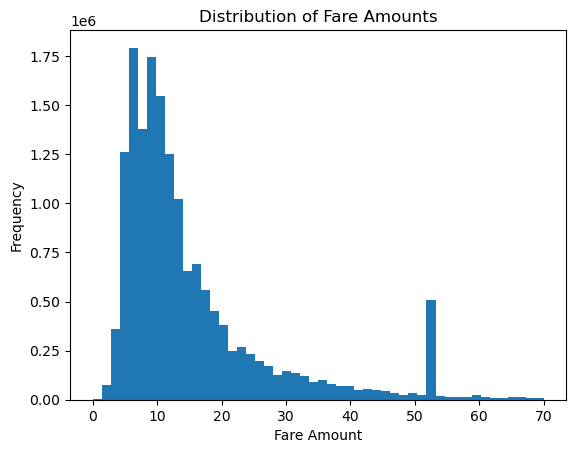

In [44]:
# Plot a histogram of the 'fare_amount' column
plt.hist(df1['fare_amount'], bins=50)

# Set the x-axis label
plt.xlabel('Fare Amount')

# Set the y-axis label
plt.ylabel('Frequency')

# Set the plot title
plt.title('Distribution of Fare Amounts')

# Show the plot
plt.show()

Fare Amount column is right skewed

C:\Users\Randhir Singh\AppData\Local\Temp\ipykernel_1176\2342528560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['fare_amount_log'] = np.log(df1['fare_amount'])


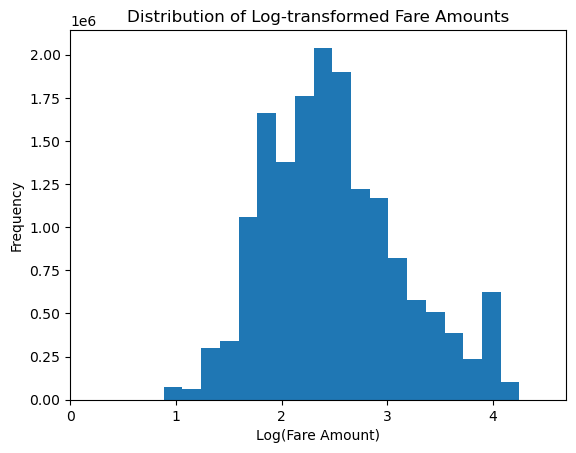

In [45]:
# Apply a natural logarithm transformation to the 'fare_amount' column
df1['fare_amount_log'] = np.log(df1['fare_amount'])

# Plot a histogram of the transformed data
plt.hist(df1['fare_amount_log'], bins=50,)

# Set the x-axis label
plt.xlabel('Log(Fare Amount)')

# Set the y-axis label
plt.ylabel('Frequency')

plt.xlim(left=0)

# Set the plot title
plt.title('Distribution of Log-transformed Fare Amounts')

# Show the plot
plt.show()

Now looks like uniform distribution but we cant have fare values as 0 so we have dropped those rows

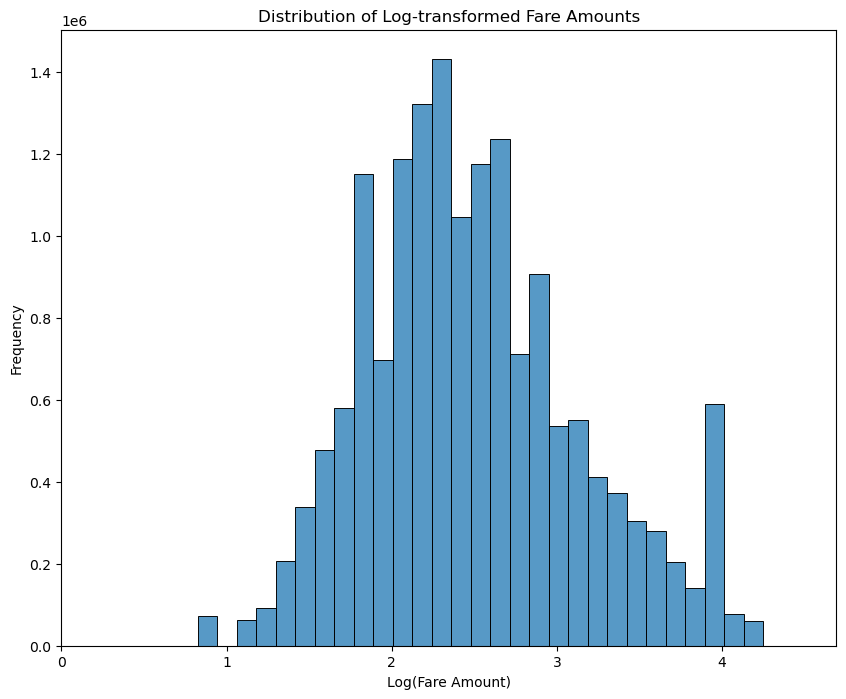

In [46]:
plt.figure(figsize=(10,8))
sns.histplot(x='fare_amount_log',data=df1, bins=75)
plt.xlabel('Log(Fare Amount)')
plt.ylabel('Frequency')
plt.xlim(left=0)
plt.title('Distribution of Log-transformed Fare Amounts')
plt.show()

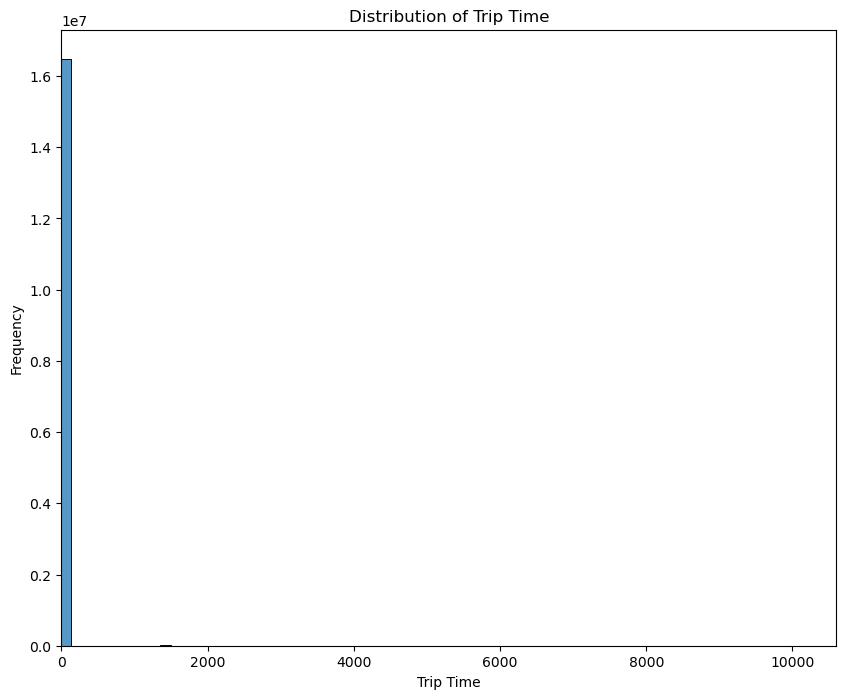

In [47]:
plt.figure(figsize=(10,8))
sns.histplot(x='trip_time',data=nyc_df, bins=75)
plt.xlabel('Trip Time')
plt.ylabel('Frequency')
plt.xlim(left=0)
plt.title('Distribution of Trip Time')
plt.show()

In [48]:
time_threshold = np.percentile(nyc_df['trip_time'], 99)
print(time_threshold)
df2= nyc_df[(nyc_df['trip_time'] < time_threshold) &(nyc_df['trip_time']!=0)]

68.23


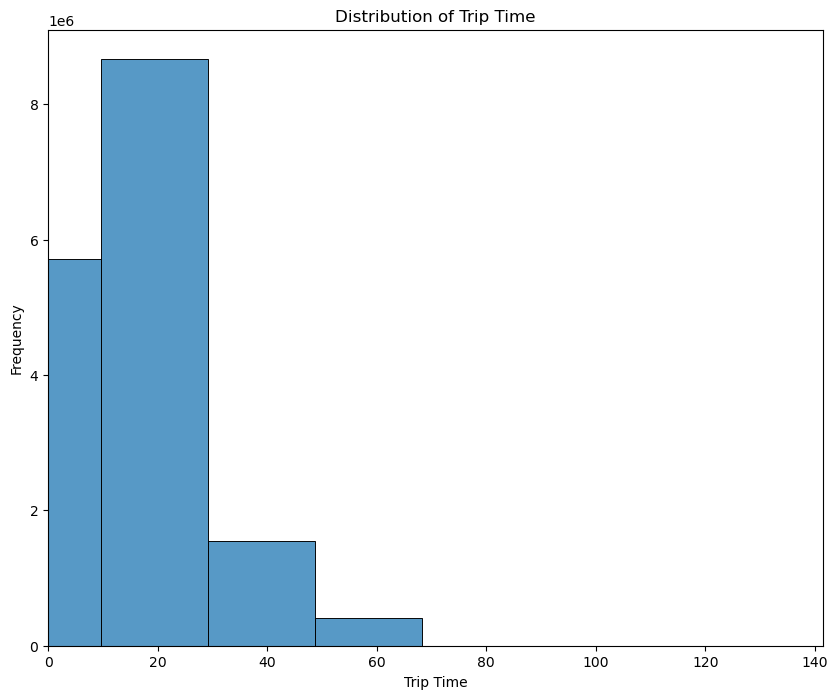

In [49]:
plt.figure(figsize=(10,8))
sns.histplot(x='trip_time',data=df2, bins=75)
plt.xlabel('Trip Time')
plt.ylabel('Frequency')
plt.xlim(left=0)
plt.title('Distribution of Trip Time')
plt.show()

In [50]:
df2['trip_time_log'] = np.log(df2['trip_time'])



E:\Anaconda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Randhir Singh\AppData\Local\Temp\ipykernel_1176\1651186313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['trip_time_log'] = np.log(df2['trip_time'])


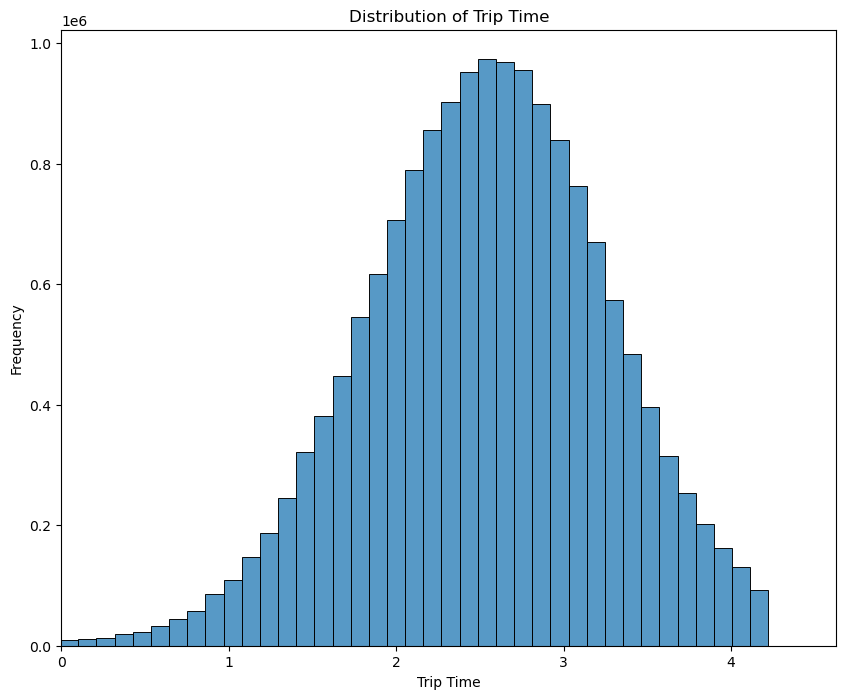

In [51]:
plt.figure(figsize=(10,8))
sns.histplot(x='trip_time_log',data=df2, bins=75)
plt.xlabel('Trip Time')
plt.ylabel('Frequency')
plt.xlim(left=0)
plt.title('Distribution of Trip Time')
plt.show()

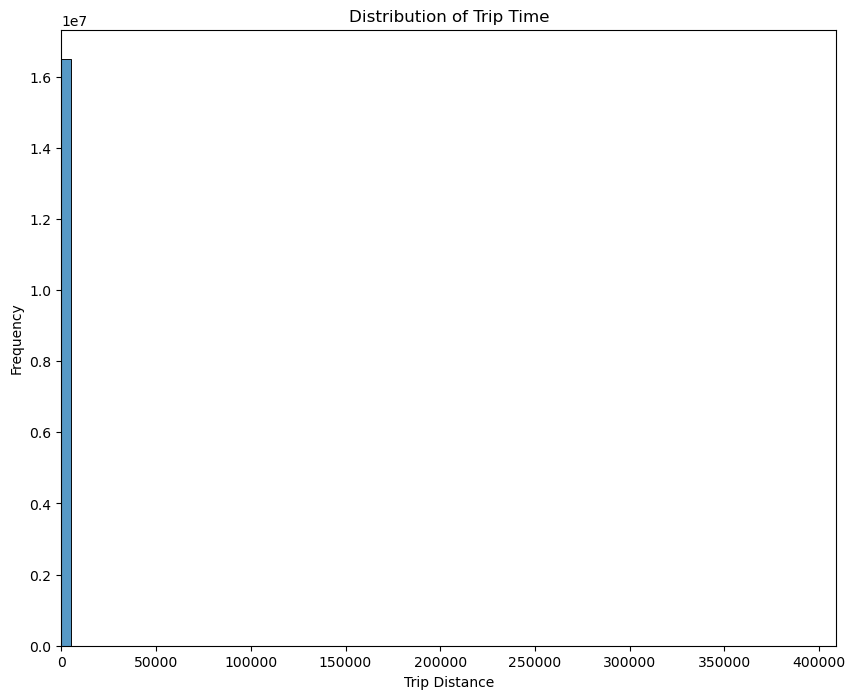

In [52]:
plt.figure(figsize=(10,8))
sns.histplot(x='trip_distance',data=nyc_df, bins=75)
plt.xlabel('Trip Distance')
plt.ylabel('Frequency')
plt.xlim(left=0)
plt.title('Distribution of Trip Time')
plt.show()

In [53]:
distance_threshold = np.percentile(nyc_df['trip_distance'], 99)
print(distance_threshold)
df3= nyc_df[(nyc_df['trip_distance'] < distance_threshold) &(nyc_df['trip_distance']!=0)]

20.33


In [54]:
df3['trip_distance_log'] = np.log(df3['trip_distance'])

C:\Users\Randhir Singh\AppData\Local\Temp\ipykernel_1176\2730869077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['trip_distance_log'] = np.log(df3['trip_distance'])


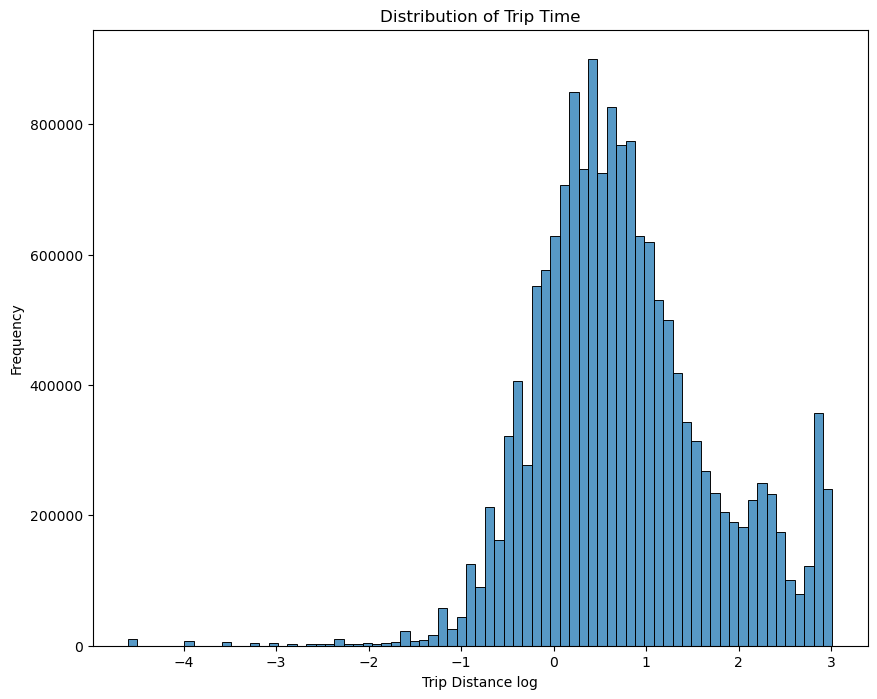

In [55]:
plt.figure(figsize=(10,8))
sns.histplot(x='trip_distance_log',data=df3, bins=75)
plt.xlabel('Trip Distance log')
plt.ylabel('Frequency')
plt.xlim()
plt.title('Distribution of Trip Time')
plt.show()

In [56]:
np.log(0.1)

-2.3025850929940455

In [57]:
nyc_df.corr()

,VendorID,trip_distance,PULocationID,DOLocationID,fare_amount,trip_time,day_month
VendorID,1.000000,0.002595,0.007092,-0.008316,0.047160,0.022496,0.005466
trip_distance,0.002595,1.000000,-0.001143,-0.001433,0.009021,0.002197,-0.000251
PULocationID,0.007092,-0.001143,1.000000,0.075949,-0.107767,-0.029831,0.001549
DOLocationID,-0.008316,-0.001433,0.075949,1.000000,-0.105402,-0.031440,0.000415
fare_amount,0.047160,0.009021,-0.107767,-0.105402,1.000000,0.237400,0.021248
trip_time,0.022496,0.002197,-0.029831,-0.031440,0.237400,1.000000,-0.004019
day_month,0.005466,-0.000251,0.001549,0.000415,0.021248,-0.004019,1.000000


In [58]:
nyc_df_raw['RatecodeID'].unique()

array([ 1.,  5.,  2.,  3.,  4., 99.,  6., nan])

In [59]:
X = nyc_df.drop(['fare_amount','trip_time','day_week'],axis=1)
X.columns

Index(['VendorID', 'trip_distance', 'PULocationID', 'DOLocationID',
       'day_month'],
      dtype='object')

In [60]:
nyc_df.columns

Index(['VendorID', 'trip_distance', 'PULocationID', 'DOLocationID',
       'fare_amount', 'trip_time', 'day_week', 'day_month'],
      dtype='object')

In [61]:
y = nyc_df['trip_time']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=123)

In [63]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13197983, 5), (3299496, 5), (13197983,), (3299496,))

In [64]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [65]:
lr_y_pred = lr.predict(X_test)
lr_mse = mean_squared_error(y_test,lr_y_pred)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test,lr_y_pred)
print("MSE : ",lr_mse)
print("RMSE : ", lr_rmse)
print("MAE : ",lr_mae)


MSE :  2097.53931159752
RMSE :  45.79890076844116
MAE :  11.083300439522933


In [65]:
rf = RandomForestRegressor(random_state=123,
                           n_jobs=-1,
                           max_depth=3,
                           n_estimators=100,
                           min_samples_leaf=3,)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, min_samples_leaf=3, n_jobs=-1,
                      random_state=123)

In [66]:
rf_y_pred = rf.predict(X_test)
rf_mse = mean_squared_error(y_test,rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test,rf_y_pred)
print("MSE : ",rf_mse)
print("RMSE : ", rf_rmse)
print("MAE : ",rf_mae)


MSE :  1983.0593744050452
RMSE :  44.531554816837975
MAE :  6.857197370487403


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


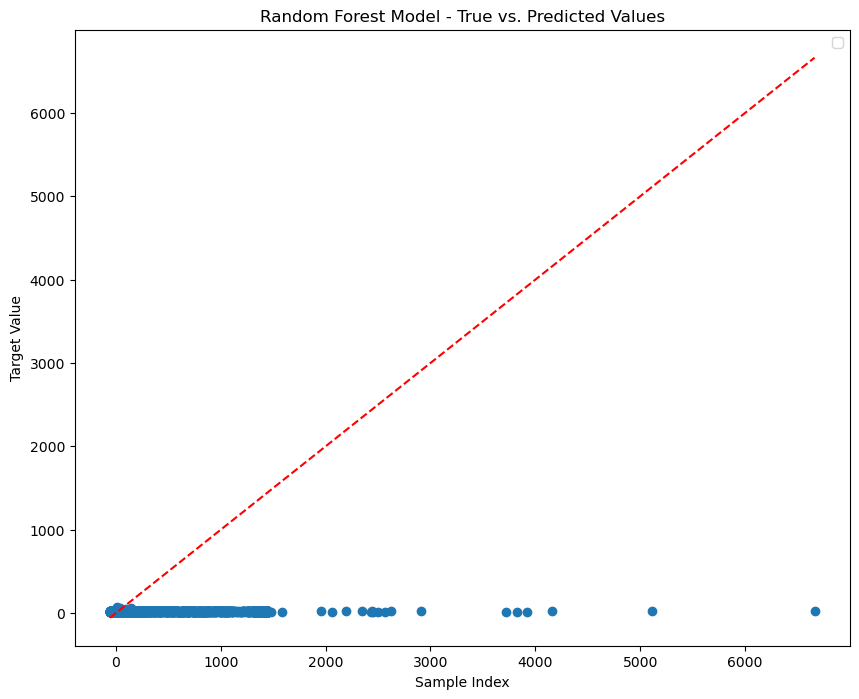

In [84]:
plt.figure(figsize=(10,8))
plt.scatter(y_test, lr_y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')

plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Random Forest Model - True vs. Predicted Values')
plt.show()

In [85]:
lr_y_pred

array([21.50373826, 19.72546305, 15.59669411, ..., 18.48541569,
       15.76025031, 19.18557159])

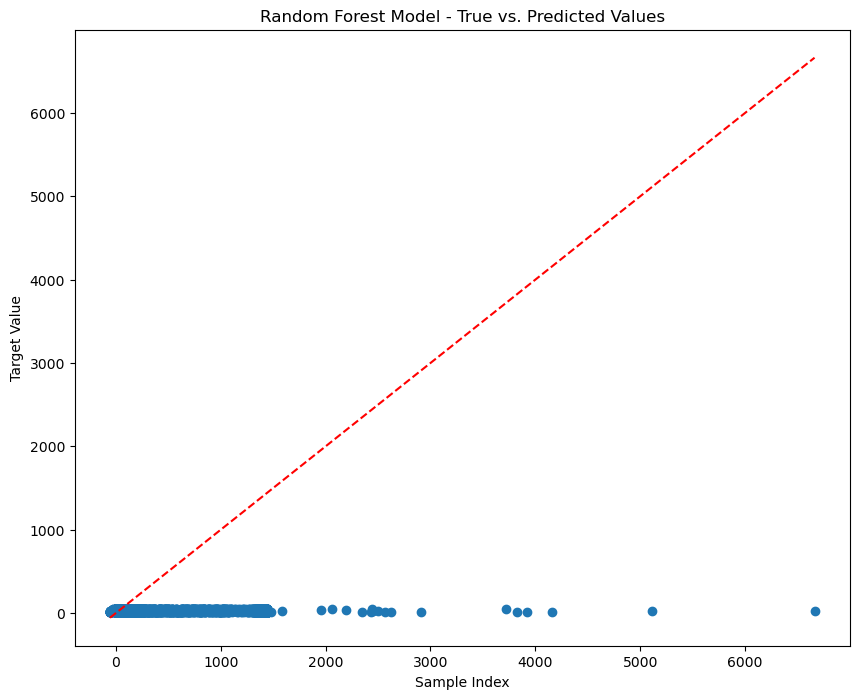

In [86]:
plt.figure(figsize=(10,8))
plt.scatter(y_test, rf_y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')

plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Random Forest Model - True vs. Predicted Values')
plt.show()

In [68]:
xgr = xgb.XGBRegressor()
xgr.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [69]:
xgr_y_pred = xgr.predict(X_test)
xgr_mse = mean_squared_error(y_test,xgr_y_pred)
xgr_rmse = np.sqrt(xgr_mse)
xgr_mae = mean_absolute_error(y_test,xgr_y_pred)
print("MSE : ",xgr_mse)
print("RMSE : ", xgr_rmse)
print("MAE : ",xgr_mae)

MSE :  1970.1318778443851
RMSE :  44.38616764088093
MAE :  6.284520765979962


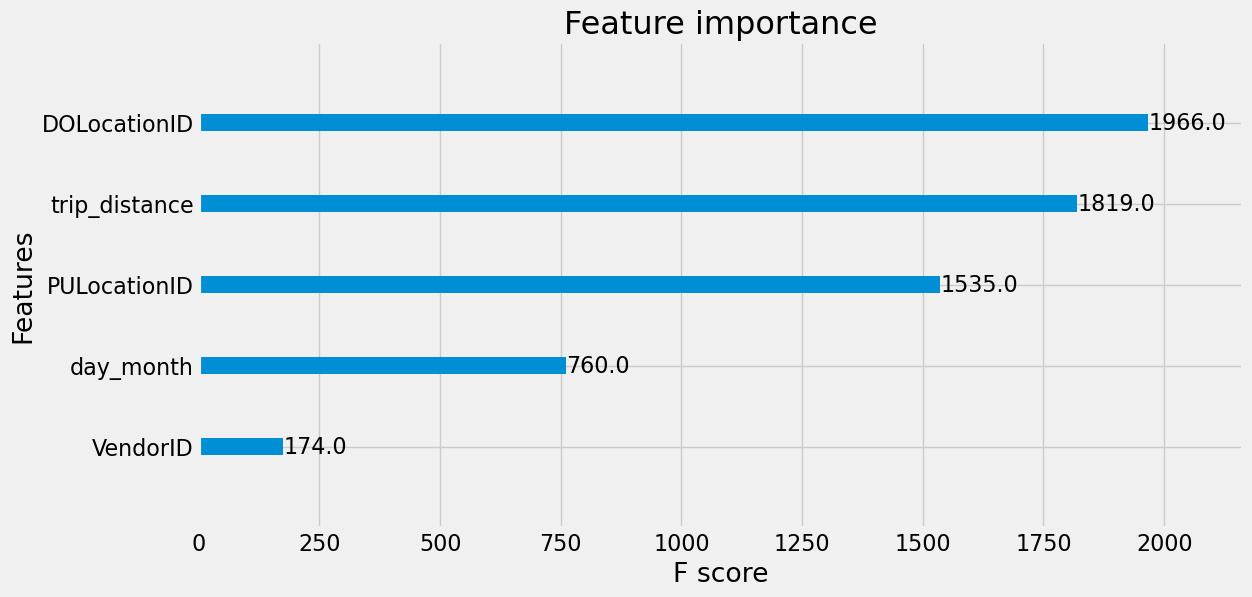

In [70]:
from xgboost import plot_importance

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(xgr, ax=ax)
plt.show();

## Base Model

We will save xgr as our base model and start working on transformations and feature engineering on that

In [80]:
import pickle

filename = '../models/base_notebook_xgboost_model.pkl'
pickle.dump(xgr, open(filename, 'wb'))
